# Import packages

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import Sequential
from tensorflow.keras.applications import Xception,resnet
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input,DepthwiseConv2D, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,ReLU,AvgPool2D,Layer)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
IMAGE_SIZE = 256

# Split the dataset into training and testing

In [4]:
train_dir = "/kaggle/input/monument-dataset/dataset_monunet"

CONFIGURATION = {
    "BATCH_SIZE": 8,
    "IMAGE_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "EPOCHS": 50,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 13,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "class_names" : ['Belur Math,Kolkata,India','Black Hole Monument,Kolkata,India','Dakshineswar Kali Temple,Kolkata,India','Fort William,Kolkata,India','Howrah Bridge,Kolkata,India','James Princep Memorial,Kolkata,India','Marble Palace,Kolkata,India','Metcalfe Hall,Kolkata,India','Raj Bhavan,Kolkata,India','Shaheed Minar,Kolkata,India','St. Pauls Cathedral,Kolkata,India','Victoria Memorial,Kolkata,India','Writer’s Building,Kolkata,India']
}

In [5]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["class_names"], 
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"],CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 571 files belonging to 13 classes.


In [6]:
len(train_ds)

72

In [7]:
def data_split(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
    size=len(dataset)
    train_dataset=dataset.take(int(TRAIN_RATIO*size))
    val_dataset=dataset.skip(int(TRAIN_RATIO*size))
    test_dataset=val_dataset.skip(int(TEST_RATIO*size))
    test_dataset=test_dataset.take(int(TEST_RATIO*size))
    val_dataset=val_dataset.take(int(VAL_RATIO*size))
    return train_dataset,val_dataset,test_dataset
train_ds,val_ds,test_ds=data_split(train_ds,0.8,0.1,0.1)

# Resizing, Rescaling and data augmentation

In [8]:
train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
from tensorflow.keras import models, layers
resize_and_rescale = Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1.0/255) 
])

In [10]:
class Bright(Layer):
    def __init__(self):
        super().__init__()
        
    def call(self, image):
        return tf.image.adjust_brightness(image, 0.1)

In [11]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"), #horizontal and vertical flip
    RandomRotation(0.2), #Rotates
    # Bright()
])

# Model creation

In [12]:
backbone = InceptionV3(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"], 3),
    )
     
backbone.trainable = False
     
model = tf.keras.Sequential([
    Input(shape = (256, 256,3)),
    resize_and_rescale,
    data_augmentation,
    backbone,
    
#     Conv2D(32,(3,3),activation="relu",padding="same"),
#     MaxPooling2D(3,3),
    
#     Conv2D(64,(3,3),activation="relu",padding="same"),
#     Conv2D(64,(3,3),activation="relu",padding="same"),
    
#     MaxPooling2D(2,2),
    
    GlobalAveragePooling2D(),
    
    Dense(1024, activation = "relu"),
    
    BatchNormalization(),
    
    Dense(128, activation = "relu"),
    Dense(13, activation = "softmax"),
    ])

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization_94 (Bat  (None, 1024)             

# Training Analysis through Metrics

In [13]:
class Precision(tf.keras.metrics.Metric):
    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
        tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1)), tf.float32))
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())

In [14]:
class Recall(tf.keras.metrics.Metric):
    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
        tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0)), tf.float32))
        self.true_positives.assign_add(tp)
        self.false_negatives.assign_add(fn)

    def result(self):
        return self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())

In [15]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Model Compilation

In [16]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
    metrics=["accuracy",Precision(), Recall(), F1Score()]  #metrics used to track training
)

# Model Training

In [17]:
EPOCHS = 12
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=8,
    verbose=1,  
    validation_data=val_ds
)

Epoch 1/12
57/57 [==============================] - 26s 142ms/step - loss: 1.6371 - accuracy: 0.5110 - precision: 0.6825 - recall: 0.4101 - f1_score: 0.5123 - val_loss: 1.5639 - val_accuracy: 0.5536 - val_precision: 0.6744 - val_recall: 0.5179 - val_f1_score: 0.5859
Epoch 2/12
57/57 [==============================] - 2s 32ms/step - loss: 0.7789 - accuracy: 0.7588 - precision: 0.8229 - recall: 0.6930 - f1_score: 0.7524 - val_loss: 1.2423 - val_accuracy: 0.5893 - val_precision: 0.6585 - val_recall: 0.4821 - val_f1_score: 0.5567
Epoch 3/12
57/57 [==============================] - 2s 32ms/step - loss: 0.5402 - accuracy: 0.8224 - precision: 0.8706 - recall: 0.7675 - f1_score: 0.8159 - val_loss: 0.7659 - val_accuracy: 0.7500 - val_precision: 0.8400 - val_recall: 0.7500 - val_f1_score: 0.7925
Epoch 4/12
57/57 [==============================] - 2s 32ms/step - loss: 0.4803 - accuracy: 0.8640 - precision: 0.9007 - recall: 0.8355 - f1_score: 0.8669 - val_loss: 0.8978 - val_accuracy: 0.7143 - val_

# Plotting Metrics

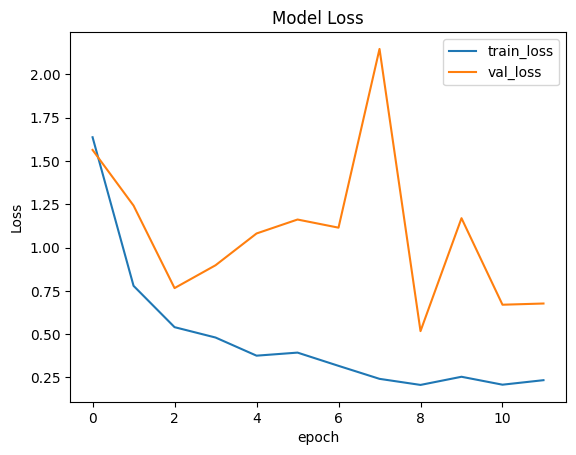

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

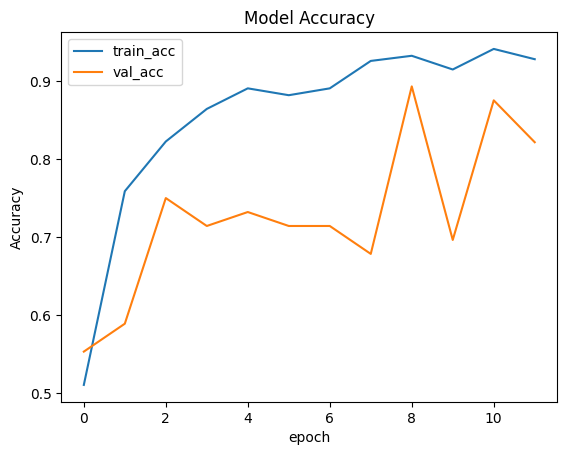

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc','val_acc'])
plt.show()

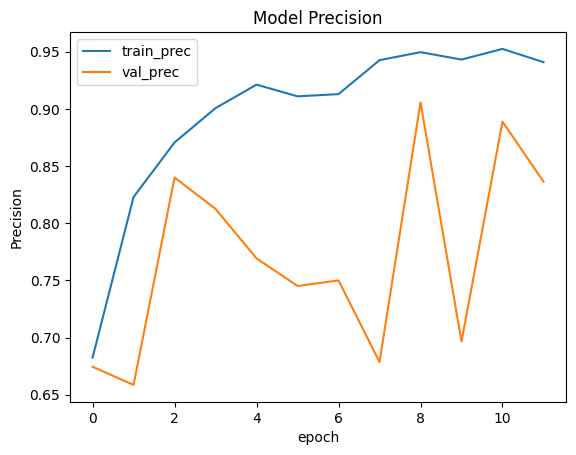

In [20]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train_prec','val_prec'])
plt.show()

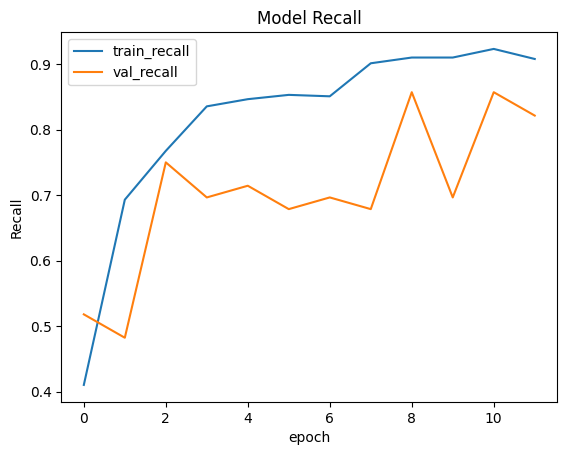

In [21]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train_recall','val_recall'])
plt.show()

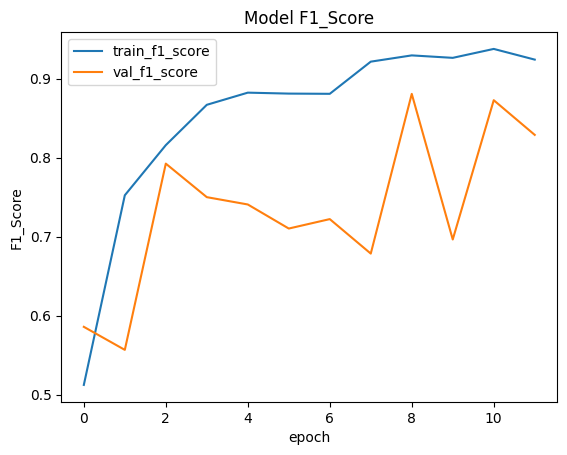

In [22]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1_Score')
plt.ylabel('F1_Score')
plt.xlabel('epoch')
plt.legend(['train_f1_score','val_f1_score'])
plt.show()

# Model Evaluation and Prediction

In [23]:
model.evaluate(test_ds)

7/7 [==============================] - 5s 29ms/step - loss: 0.4868 - accuracy: 0.8571 - precision: 0.8679 - recall: 0.8214 - f1_score: 0.8440


[0.4868197441101074,
 0.8571428656578064,
 0.8679245114326477,
 0.8214285969734192,
 0.8440366387367249]

In [24]:
# plt.figure(figsize=(24,24))
# for images, labels in test_ds.take(1):
#     for i in range(min(16, len(images))):
#         ax = plt.subplot(4,4,i+1)
#         plt.imshow(images[i]/255.)
#         plt.title("True Label : "+ CONFIGURATION["class_names"][tf.argmax(labels[i], axis=-1).numpy()] + "\n" + "Predicted Label : " + CONFIGURATION["class_names"][int(tf.argmax(model(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0])])

In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = '/kaggle/input/victoria/WhatsApp Image 2023-11-24 at 12.51.17.jpeg'
img = load_img(image_path, target_size=(256, 256))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)

1/1 [==============================] - 2s 2s/step


In [26]:
class_labels = ['Belur Math,Kolkata,India','Black Hole Monument,Kolkata,India','Dakshineswar Kali Temple,Kolkata,India','Fort William,Kolkata,India','Howrah Bridge,Kolkata,India','James Princep Memorial,Kolkata,India','Marble Palace,Kolkata,India','Metcalfe Hall,Kolkata,India','Raj Bhavan,Kolkata,India','Shaheed Minar,Kolkata,India','St. Pauls Cathedral,Kolkata,India','Victoria Memorial,Kolkata,India','Writer’s Building,Kolkata,India']  # Replace with your actual class labels

predicted_class_index = np.argmax(prediction)
predicted_label = class_labels[predicted_class_index]

print("Predicted Label:", predicted_label)

Predicted Label: Victoria Memorial,Kolkata,India


# Saving model

In [27]:
# model.save('MonuNetv3.h5')